# Scrubbing the NY Times

*Please direct comments and questions to the author, Professor Eric Larson, eclarson@smu.edu *

___

For this first block of code, we will simply use the requests API to manage a GET request to github. This code queries github/events, which will return the most recent activity from a user on github. Since github is used extensively, this will change likely every few milliseconds.

Notice that I am using the `closing` library in order to wrap the given requests class. Otherwise, I would need to remember to call `r.close()` after each connection. 

In [136]:
import requests
from contextlib import closing
import json
        
# get the most recent activity from github... (changes all the time)
with closing(requests.get('https://api.github.com/events')) as r:
    payload = json.loads(r.content) # make the content into JSON
    print(payload[0]['payload']) # print out some interesting stuff


{u'size': 1, u'head': u'7f9486711d7cf79e06e52d445daaa2080896b4c9', u'commits': [{u'distinct': True, u'sha': u'7f9486711d7cf79e06e52d445daaa2080896b4c9', u'message': u'make makepandacore to get Windows 10 SDK uCRT version', u'url': u'https://api.github.com/repos/MU-Software/panda3d/commits/7f9486711d7cf79e06e52d445daaa2080896b4c9', u'author': {u'email': u'musoftware@daum.net', u'name': u'MUsoftware'}}], u'distinct_size': 1, u'push_id': 1254697410, u'ref': u'refs/heads/master', u'before': u'20353f33eb7fffa90135909565097bebc210a525'}


___
## Requesting from the NYTimes
To run this code, you will need a free API key from the NYTimes. For me, this is saved in a parent directory to the repository, saved in plain text. Next, we will use the requests API to query the NYTimes for recent articles. 

The GET request we generate has base URL and a set of public, plain text parameters. In this example, I am requesting queries for anything about the Olympics. To create the GET request URL, the key/value pairs of the request are stored using a python dictionary. Its straight forward.

Once we have information from the base URL, we access the `content` portion of the GET request. This is saved as text but we can use the builtin json decoder to convert the text into a python dictionary.

In [32]:
import requests
import json
from contextlib import closing

# get API key saved on hardrive
with open('../NYTimesAPI.txt') as f:
    api_key = f.read() # read in my private key (sorry, not in this repo ¯\_(ツ)_/¯ )
    
# make base URL and dictionary of get request key/values
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
payload = {'api-key': api_key, 'q': 'Olympics'} # key/values for get request (look up in api, there are lots)

# [erform the actual request]
with closing(requests.get(url,params=payload))as r:
    json_payload = json.loads(r.content)
    print(json_payload)



{u'status': u'OK', u'response': {u'docs': [{u'type_of_material': u'News', u'blog': [], u'news_desk': u'Sports', u'lead_paragraph': u'When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women\u2019s marathon, they quickly drew sharp criticism from their federation.', u'headline': {u'main': u'Twins Finish Marathon Hand in Hand, but Their Country Says They Crossed a Line', u'kicker': u'On Olympics', u'print_headline': u'Hand in Hand: Did Their Finish Cross a Line?', u'content_kicker': u'On Olympics'}, u'abstract': None, u'print_page': u'10', u'word_count': None, u'_id': u'57b392797988101da6e76f62', u'snippet': u'When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women\u2019s marathon, they quickly drew sharp criticism from their federation.', u'source': u'The New York Times', u'slideshow_credits': None, u'web_url': u'http://www.nytimes.com/2016/08/17/sports/olympics/twins-finish-marathon-hand-in-han

The structure of the json file is much like what you would expect: we have some information about the number of returned articles and the main information is in a key `docs` which has an array of dictionary objects, each entry with metadata about the article. 

For example, the docs array might look like this, where ellipses denote other entries:

`
{'docs': [{ ..., 'subsection_name': 'Olympics', ...}, 
          { ..., 'subsection_name': 'Book Review', ...}, 
          { ..., 'subsection_name': 'Times Insider', ...},
          ...
          ]
}
`

This means that we can access specific article information by getting the article index from the `docs` list. Then we can access metadata about the article from the list entry. See the example below for getting the lead paragparh of the article.

In [137]:
some_article = json_payload['response']['docs'][0] # the first article in the docs
print(some_article['lead_paragraph'])

When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.


There is an incredible amount of information to get from these articles. For instance, each article has a list of the images used in the article. For instance, in the previous example, we can access the list of multimedia images used from the `multimedia` key. Then we can grab the image URL by using the `url` key for the media in the list. See the next block for an example of this:

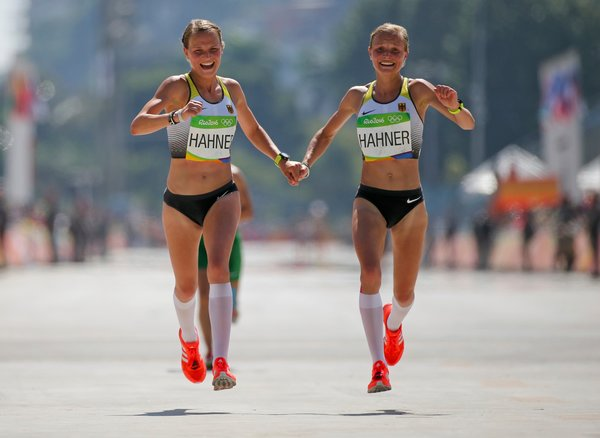

In [33]:
from IPython.display import Image
img_url = 'http://www.nytimes.com/'+ some_article['multimedia'][1]['url']
Image(img_url)


___
# Wrapping the articles in a custom class for functionality
Now that we know what the overall article metadata looks like, lets create a custom class for getting access to this data more intuitively. Specifically, let's create an NY Article class.

In [151]:
# okay, so lets create a custom wrapper class for the articles returned by the NYTimes
# as input, we will take the docs and then we will add functions to easily get the content

class NYArticle(object):
    def __init__(self,article_data):
        self.data = article_data # should already be decoded JSON dictionary when passed in
        self.keys = article_data.keys()
        
    def get(self,param='type_of_material'): # generic getter for any part of article
        if param in self.keys: # prevent key errors
            return self.data[param]
        else:
            return None
        
# test this bare bones implementation
json_docs = json_payload['response']['docs']
article = NYArticle(json_docs[0])
print(article.get('lead_paragraph'))

When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.


In [152]:
# now let's add some custom functionality to the class for getting arbitrary params and a summary of the article
class NYArticle(object):
    def __init__(self,article_data):
        self.data = article_data # should already be decoded JSON dictionary when passed in
        self.keys = article_data.keys()
        
    def get(self,param='type_of_material'): # generic getter for any part of article
        if param in self.keys and self.data[param]!=None: # prevent key errors
            return self.data[param]
        else:
            return ''
        
    def summary(self): # agglomerate some info on article
        summary_inclusion = ['snippet','lead_paragraph','abstract']
        vals = [self.get(x) for x in summary_inclusion]
        return '\n'.join(vals)
        
# tese this bare bones implementation
json_docs = json_payload['response']['docs']
article = NYArticle(json_docs[0])
print(article.summary())

When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.
When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.



This is looking a lot better, but we really want to have an implementation to get information from anywhere, regardless of how many dictionaries we need to get through.

To do this, we will use some recursion to iteratively call the same function until we find the key we are looking for. 

In [153]:
# now let's add some a nested functionality for getting article text, regradless of where it is
class NYArticle(object):
    def __init__(self,article_data):
        self.data = article_data # should already be decoded JSON dictionary when passed in
        self.keys = article_data.keys()
        
    def get(self,param='type_of_material'): # generic getter for any part of article
        # now implement this with recursion
        if param in self.keys and self.data[param]!=None: # prevent key errors
            return self.data[param]
        else:
            return 'None'
        
    def get_recurse(self,params=['type_of_material']):
        def recursion(data,params):
            if isinstance(data, dict) and len(params)>0 and params[0] in data.keys(): # still have recursions to do
                return recursion(data[params[0]],params[1:])
            elif data==None:
                return ''
            elif isinstance(data,unicode) or isinstance(data,str):
                return data
            else:
                return ''
                  
        return recursion(self.data,params)
        
    def summary(self): # agglomerate some info on article
        summary_inclusion = [['headline','main'],
                             ['headline','print_headline'],
                             ['news_desk'],
                             ['section_name'],
                             ['subsection_name'],
                             ['snippet'],
                             ['lead_paragraph'],
                             ['abstract']]
        vals = [self.get_recurse(x) for x in summary_inclusion]
        return '\n'.join(vals)
        
# tese this bare bones implementation
json_docs = json_payload['response']['docs']
article = NYArticle(json_docs[0])
print(article.summary())

Twins Finish Marathon Hand in Hand, but Their Country Says They Crossed a Line
Hand in Hand: Did Their Finish Cross a Line?
Sports
Sports
Olympics
When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.
When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.



In [142]:
# now it is very easy to get a summary of each of the articles
articles = [NYArticle(x) for x in json_docs]
for a in articles:
    print('\n======================')
    print(a.summary())


Twins Finish Marathon Hand in Hand, but Their Country Says They Crossed a Line
Hand in Hand: Did Their Finish Cross a Line?
Sports
Sports
Olympics
When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.
When the German twins Anna and Lisa Hahner joined hands as they finished deep in the pack in the women’s marathon, they quickly drew sharp criticism from their federation.


The Dark History of the Olympics
Tarnish on the Torch
BookReview
Books
Book Review
David Goldblatt’s “The Games” recalls unflattering aspects of the Olympics long before doping and gender testing.
David Goldblatt’s “The Games” recalls unflattering aspects of the Olympics long before doping and gender testing.
Mary Pilon reviews book The Games: A Global History of the Olympics by David Goldblatt.

Barring Russia’s Team, Not Just Individuals, Is a Powerful Move
Watchdogs Show Teeth and, Finally, Some Sp

## Adding mutimedia display to images
So now that we have the leading text from the articles, it would be great to get the images from each of the articles. Since we have the image URL inside the multimedia key for the articles, we can do this effectively with the the `io` API that comes with scikit-image. This library is useful for all kinds of feature extraction techniques and also converting images into numpy matrices. That is no small feat given the mutitude of ways in which images might be encoded or compressed. 

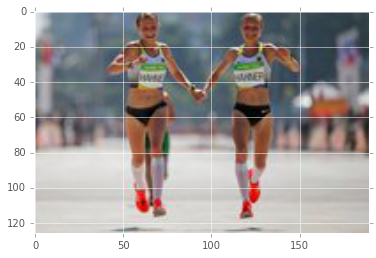

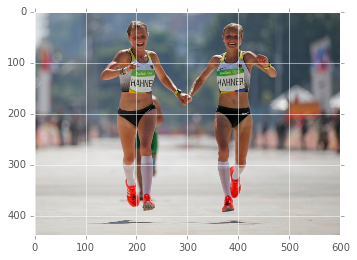

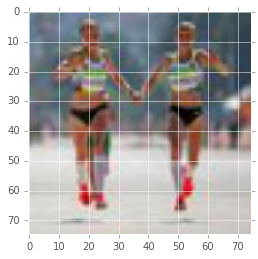

In [154]:
# okay great, we have some bare bones article classes. Now, lets add some multimedia functionality
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

class NYMultimedia():
    def __init__(self,multimedia):
        self.media = multimedia
        self.image = None
        
    def get_image(self):
        # don't download if we already did
        if self.image == None:
            url = 'http://www.nytimes.com/'+ self.media['url']
            self.image = io.imread(url)

        return self.image
        

class NYArticleWithMedia(NYArticle): # inherit all the functionality from above
    def __init__(self,article_data): #overwrite the init function

        super(NYArticleWithMedia, self).__init__(article_data) # call super class
        
        self.num_media = len(self.data['multimedia'])
        self.multimedia = [NYMultimedia(x) for x in self.data['multimedia']] # list of media objects
        
    def show_images(self):
        for m in self.multimedia:
            img = m.get_image()
            plt.figure()
            plt.imshow(img)
            
        plt.show()
        
    def get_images(self):
        imgs = []
        for m in self.multimedia:
            img = m.get_image()
            imgs.append(img)
            
        return imgs

        
a = NYArticleWithMedia(json_docs[0])
a.show_images()

Now let's display the images side by side.

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


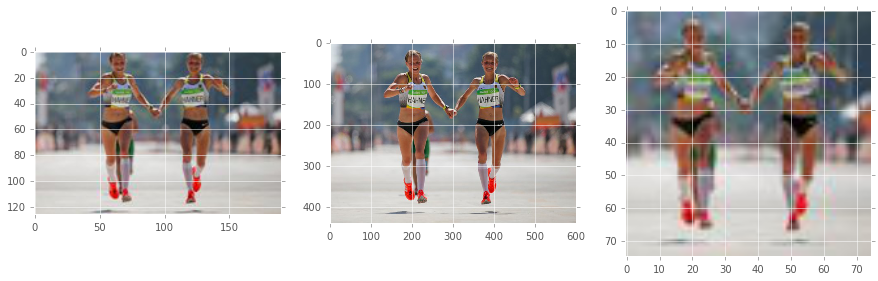

In [155]:
imgs = a.get_images()

plt.figure(figsize=(15,5))
for i,im in enumerate(imgs):
    plt.subplot(1,len(imgs),i+1)
    plt.imshow(im)
    
plt.show()

Hmmm... These images are getting displayed at the exact same resolution, despite the differences in image sizes. Lets fix that using the `gridspec` function of matplotlib. All we need is some descriptor for each image that tells us what size it should be in relation to the other images. 

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


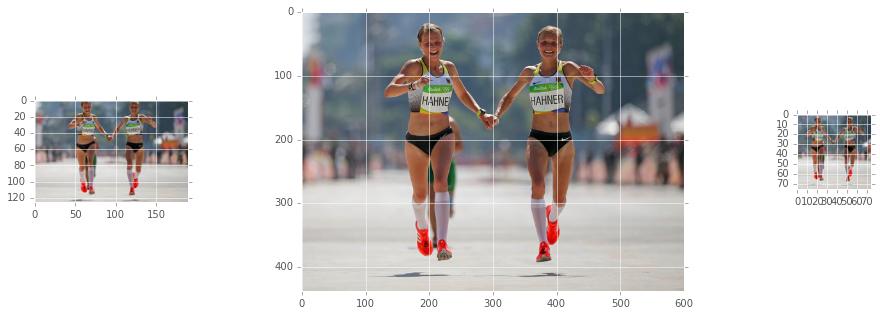

In [156]:
# but we really want to show more size appropriate versions of the images

from matplotlib import gridspec

imgs = a.get_images()
rows = [round(np.sqrt(img.shape[1]*img.shape[0])) for img in imgs] # get num rows for each image

plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, len(imgs), width_ratios=rows)
for i,im in enumerate(imgs):
    plt.subplot(gs[i])
    plt.imshow(im)
    
plt.show()

___
And og course, we should do it for every image in every article!

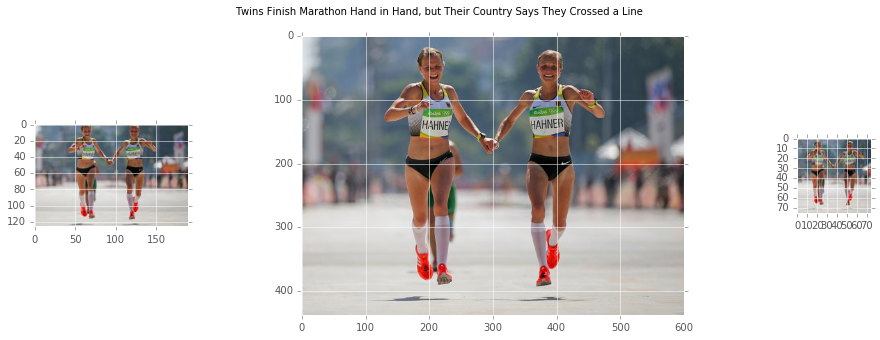

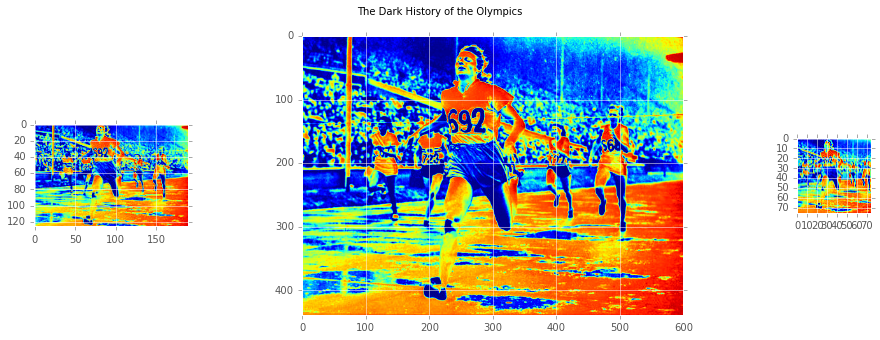

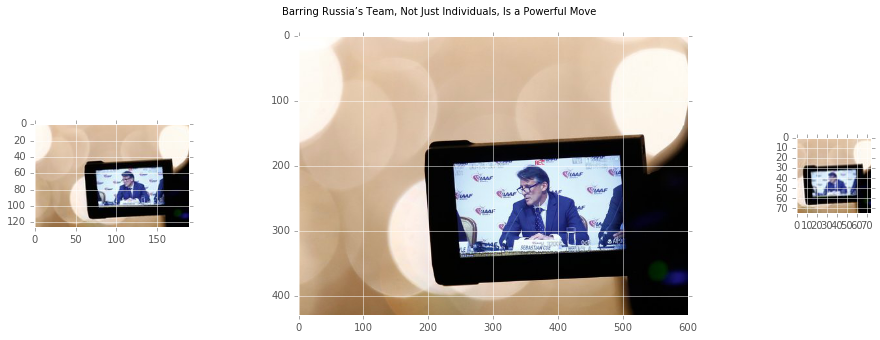

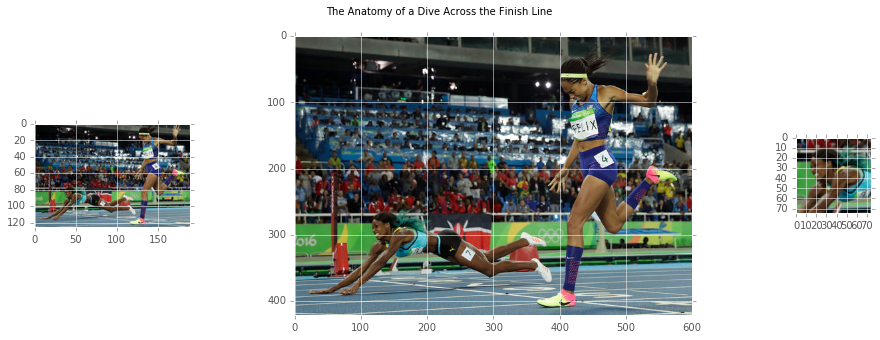

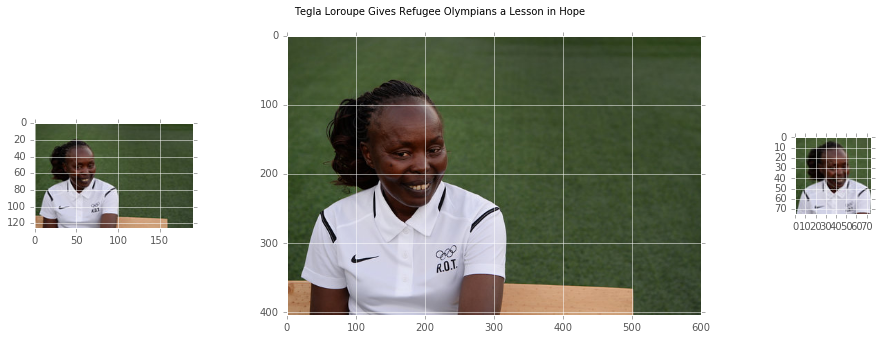

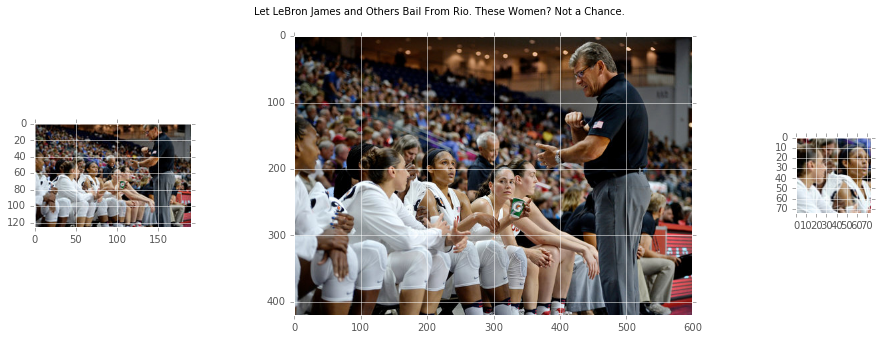

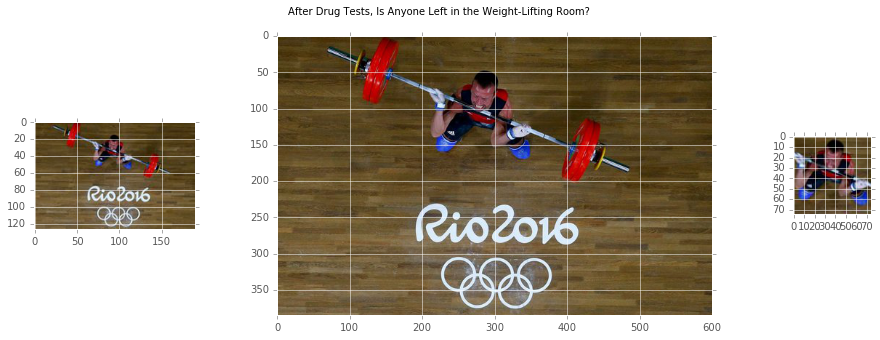

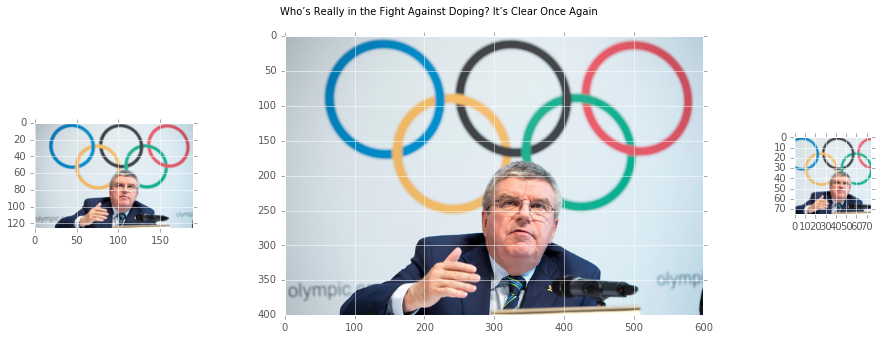

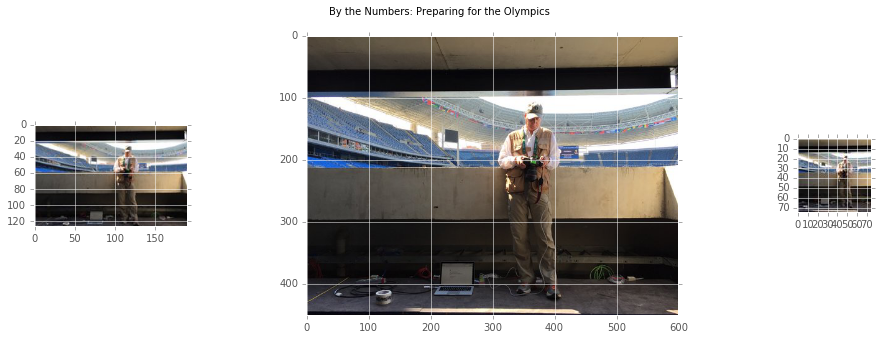

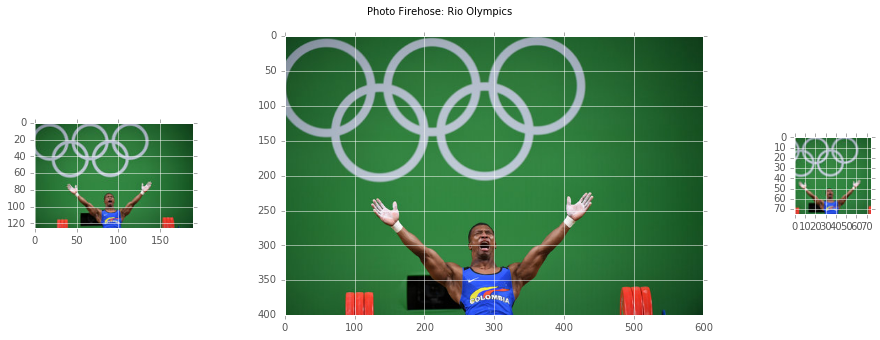

In [157]:
# create figures for all the different images in each article
def plot_all(a):
    imgs = a.get_images()
    rows = [round(np.sqrt(img.shape[1]*img.shape[0])) for img in imgs] # get num rows for each image

    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, len(imgs), width_ratios=rows)
    for i,im in enumerate(imgs):
        plt.subplot(gs[i])
        plt.imshow(im)
    
    fig.suptitle(a.get_recurse(['headline','main']))
    
    
articles = [NYArticleWithMedia(x) for x in json_docs]
for a in articles:
    plot_all(a)
    
plt.show()

## Finally, lets just create some image features
For this example we will resize each image, make it gray scale, and calculate the histogram of ordered gradients for the image. We can then stack these features, row by row, into a numpy matrix. 

In [158]:
# what if we wanted to alter these images so that we calculated features from them?
from skimage.feature import ORB, hog
from skimage.color import rgb2gray
from skimage.transform import resize

def extract_features(a):
    imgs = a.get_images()
    
    extractor = ORB(n_keypoints=10)
    
    tmp = []
    for i,im in enumerate(imgs):
        if im != None:
            img_gray = resize(rgb2gray(im),(25,25))
            tmp.append(hog(img_gray))
  
    return tmp
    
    
features = [] 
for a in articles:
    features = features + extract_features(a)
    
features = np.vstack(features)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


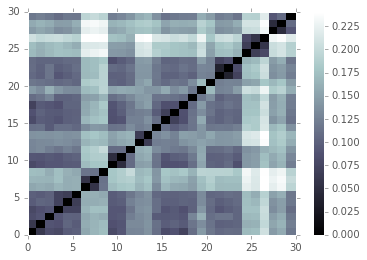

In [159]:
# and then we can take the distance between each image feature vector
from sklearn.metrics.pairwise import pairwise_distances
plt.style.use('ggplot')

dists = pairwise_distances(features, metric='euclidean')

plt.pcolor(dists,cmap=plt.cm.bone)
plt.colorbar()